# Data Description

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results
The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
The date in yyyy-mm-dd format
The local time of day in hh:mm:ss 24-hour format
The numeric data, if any (may be an empty string)
The text data, if any (may be an empty string)

The units of each dataset are:

- Solar radiation: watts per meter^2
- Temperature: degrees Fahrenheit
- Humidity: percent
- Barometric pressure: Hg
- Wind direction: degrees
- Wind speed: miles per hour
- Sunrise/sunset: Hawaii time

Link: https://www.kaggle.com/datasets/dronio/SolarEnergy

1. Importing Libraries
2. Loading Data
3. Data Wrangling
4. Feature Selection using Correlation Matrix
5. Feature Selection using SelectKBest Method
6. Feature Selection using Extra Tree Classifier
7. Feature Engineering with BoxCox, Log, Min-Max and Standard transformation
8. Preparing data - Standardisation and Splitting
9. Prediction with XGBoost
10. Using MultiLayer Perceptron for prediction

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import re #using regular expression because at time fo feature engineering use python daytime package as weel as  

#dealing with ml models and working with datasets
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#similar to random forest and work like that used for extracting the feature importtance adn use select kbest method
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

#!pip install xgboost
import xgboost as xgb

#!pip install tensorflow
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# LOADING DATA

In [2]:
data=pd.read_csv("SolarPrediction.csv")#solar_irradiance data.csv

In [3]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()#11 col 10 input paramter and one target parameter

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data Wrangling

In [5]:
df=data.copy()

In [6]:
#extract month data year from it
st="9/29/2016 12:00:00 AM"
st.split()#bydeafault take space

['9/29/2016', '12:00:00', 'AM']

In [7]:
 df['Data']=df["Data"].apply(lambda x: x.split()[0])#return  the 0th index

In [8]:
df.head()#now data has date column changes

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [9]:
#extract month
#it is in date-time format
# extract the date time features from the given parameter using date time python methods
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [10]:
#pd.to_datetime(df['Data']).dt.month
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,0,20,4
32682,1480587301,12/1/2016,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,0,15,1
32683,1480587001,12/1/2016,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,0,10,1
32684,1480586702,12/1/2016,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,0,5,2


-->df['TimeSunRise'].apply(lambda x : ...): This applies a function to each element in the TimeSunRise column.

-->aims to match digits (\d+) that are preceded by a colon (:) and followed by a colon (:). This pattern works for extracting the minutes part from a time string formatted as "HH:MM

Explanation of the Regex
-->  (?<=\:): Positive lookbehind assertion. Ensures that the match is preceded by a colon.

-->  \d+: Matches one or more digits.

-->  (?=\:): Positive lookahead assertion. Ensures that the match is followed by a colon.

-->In the context of the lambda function used within apply, the x refers to each individual element of the pandas Series (in this case, each value in the TimeSunRise column). When you use apply, it applies the lambda function to each element in the Series, and x is the placeholder for each element during this process.

In [11]:
# extract the sunrise and sunset information hours and minutes using regular expression
#we will search out for regular expression we want to extract the "r" 
#'\d' means it will take all digit currently have and when apply symbol over here "^\d" it will do  the matching the first initial machine can see matches the beggining of the string.
#^ - (Beginning)=matches the beginning of the string or the beginning of a line if a multiline flag(m) is enabled.
#\d matches any digit character(0-9)
# by this "'^\d" it will take only 0 from 06:13:00
#and if take "\d" it will take whole string 06:13:00
# by this "'^\d" it will take only nothing from a06:13:00
# by this "'^\d" it will take only 4 from 4a06:13:00
# by this "'^\d+' " it will take only 4 from 4a06:13:00 beacuse a will disconnect them

#and '^\d+' we want it to keep doing it till we have digit for that we put + sign over here so it will look for one or occurence
# by this "'^\d+' " it will take only 06 from 06:13:00 
# by this "'^\d+' " it will take only 060606 from 060606:13:00 

#this whole will apply on string so use astype method to convert it to int
df['risehour']=df['TimeSunRise'].apply(lambda x: re.search(r'^\d+',x).group(0)).astype(int)#we will take group 1 which is at index 0 over here 

#now for a minute to pick something in between having digit around and between that digit

df['riseminutes'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [12]:
df.head()#all data information is extracted over here

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int64  
 12  Day                     32686 non-null  int64  
 13  Hour                    32686 non-null  int64  
 14  Minute                  32686 non-null

In [14]:
#no need of parameter and extracted all from data paramter so remove it and for sun rise and set
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1,inplace=True)

In [15]:
df.shape

(32686, 15)

In [16]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [17]:
df.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
risehour                  0
riseminutes               0
sethour                   0
setminute                 0
dtype: int64

In [18]:
#Splitting this dataFrame into input feature that we need which is donw by feature selections
input_features=df.drop(['Radiation'],axis=1)
target=df['Radiation']

# Feature Selection using Correlation Matrix

$$
r=\frac{\sum\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)}{\sqrt{\sum\left(x_i-\bar{x}\right)^2 \sum\left(y_i-\bar{y}\right)^2}}
$$
- $r=$ correlation coefficient
- $x_i=$ values of the $\mathrm{x}$-variable in a sample
- $\bar{x}=$ mean of the values of the $\mathrm{x}$-variable
- $y_i=$ values of the $y$-variable in a sample
- $\bar{y}=$ mean of the values of the $y$-variable

In [19]:
#it is just a algorithm in which direction you can look for
corr_matrix=df.corr()
corr_matrix
#between 2 paramter same is always be 1 and rest for from -1 to 1 
#we do this to know how other variable are correlated to the target variable 

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


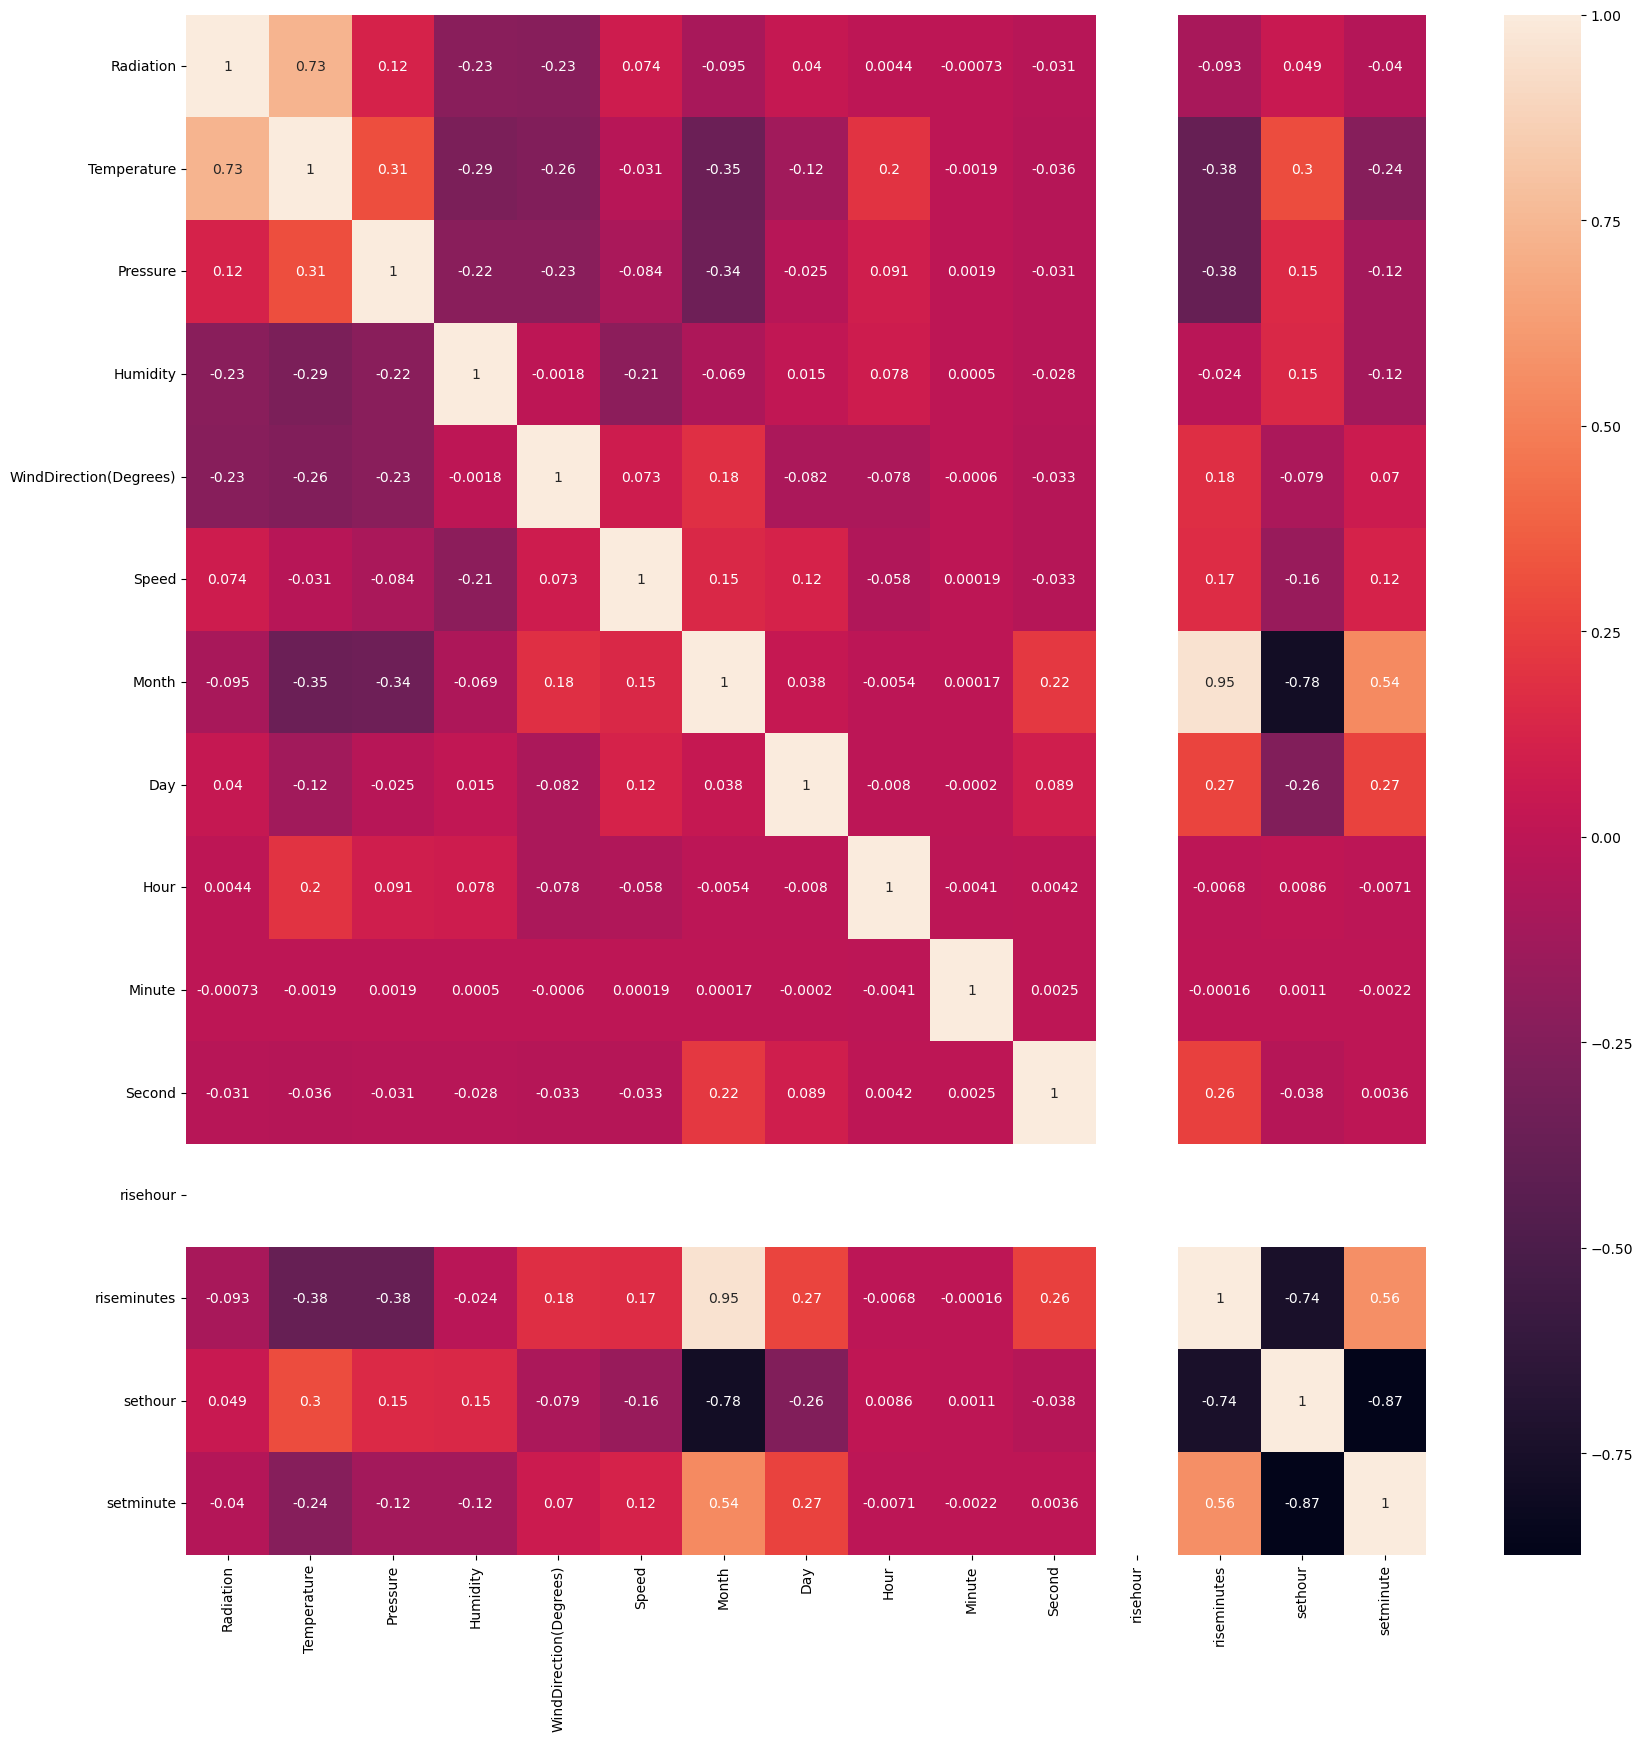

In [20]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)
plt.show()
#it is strange here that solar radiation the power of radiation depend on hour of the day if afternoon sun is at peaked 
#at that point correlation will be high w.r.t to radiation
#temp relation also be high
#so by this get which paramter are more imp so during training take that paramater not need to take all parameter. 

# Feature Selection using SelectKBest Method

GFG article link to $chi^{2}$ test - https://www.geeksforgeeks.org/chi-square-test-for-feature-selection-mathematical-explanation/

In [21]:
#selectKBest is another best algo using this tries to tell the importance of the fature w.r.t target parameter
#this score_fun  is correlation or some other statistical test for this model used chi-square for feature selection
#for almost all features that have what tis importance that i am getting k=10
bestfeatures = SelectKBest(score_func=chi2,k=10)

It works on the target label but instead we are passsing continuous float values to it. So, we need to convert our data to label form and there are two methods as follows:
- usign LabelEncoder
- multiplying the data by 100 and converting it to int which can be treated as labels by the model

In [22]:
#now how to use this method# call bestfeatures by this method
#fit=bestfeatures.fit(input_features,target)
#selectKbest select target as labels but because you have float value in it you cannot convert float values to label format.
#so for that we have 2 method labelencoding


In [23]:
# use the label encoder it will convert your float when used
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(target)#so this one way of doing it.

In [24]:
#this is onw to convert continuous float value in label encoder
train_Y#so now it has been converted to labels so where having 1.21=9 convert to 9 and where having and 1.20 convert to 8

array([ 9,  9, 11, ...,  8, 11,  8], dtype=int64)

In [25]:
target

0        1.21
1        1.21
2        1.23
3        1.21
4        1.17
         ... 
32681    1.22
32682    1.17
32683    1.20
32684    1.23
32685    1.20
Name: Radiation, Length: 32686, dtype: float64

In [26]:
#we can see that target values are upto 2 decimal places so multiply whole value to 100 model still have corrrealtion between values same
#another way of doing it 1.21*100=121 then pass to  model to work 
target_cont=df['Radiation'].apply(lambda x: int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(input_features)
target_cont[:5]

0    121
1    121
2    123
3    121
4    117
Name: Radiation, dtype: int64

In [27]:
fit=bestfeatures.fit(input_features,target_cont)

#scale the input feature so scaling here manes calling min-max and then fit transform the input data so that all valeus are scale and there is no bias extracting the best features.beacause paramtere like pressure can have high value.
-->so put in model without bias effet the model

In [28]:
fit.scores_#socres of the each of the parameter

array([2.04531087e+04, 1.48350718e+00, 1.34779185e+05, 1.17666127e+06,
       3.10173210e+04, 2.03750722e+03, 7.98705274e+04, 1.58972640e+04,
       1.54039612e+05, 1.35031709e+05, 2.37911441e-23, 1.49912126e+05,
       2.44803812e+02, 1.09959013e+05])

In [29]:
#prepare a df
scores=pd.DataFrame(fit.scores_)
#column of input feature
column=pd.DataFrame(input_features.columns)#so scores and column are here

In [30]:
#concentate into feature_scores
featureScores=pd.concat([column,scores],axis=1)

In [31]:
featureScores

,0,0
0,Temperature,2.045311e+04
1,Pressure,1.483507e+00
2,Humidity,1.347792e+05
3,WindDirection(Degrees),1.176661e+06
4,Speed,3.101732e+04
5,Month,2.037507e+03
6,Day,7.987053e+04
7,Hour,1.589726e+04
8,Minute,1.540396e+05
9,Second,1.350317e+05


In [32]:
#presen it efficiently
#featureScores
featureScores.columns=['Features','feature_imp']

In [33]:
featureScores.sort_values(by='feature_imp',ascending=False,inplace=True)

In [34]:
featureScores

,Features,feature_imp
3,WindDirection(Degrees),1.176661e+06
8,Minute,1.540396e+05
11,riseminutes,1.499121e+05
9,Second,1.350317e+05
2,Humidity,1.347792e+05
13,setminute,1.099590e+05
6,Day,7.987053e+04
4,Speed,3.101732e+04
0,Temperature,2.045311e+04
7,Hour,1.589726e+04


<function matplotlib.pyplot.show(close=None, block=None)>

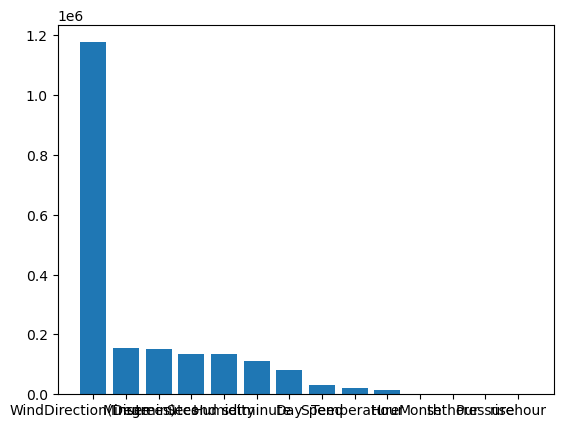

In [35]:
plt.bar(featureScores.Features,featureScores.feature_imp)
plt.show

# Feature Selection using Extra Tree Classifier

In [36]:
#so extra tree calssifier is a bagging model similiar to random forest where run some trees in parallel and you get best outcome from and you return your result,
#so initialize the model

In [37]:
#verbose is look into no of iteration
#model=ExtraTreesClassifier(n_estimators=10,verbose=2)#no of  extimator means no of tree you want
#model.fit(scaled_input_features,target_cont)#selct the best fit tree out 10 take time to debug

In [38]:
model = ExtraTreesClassifier(verbose = 2, n_estimators = 10)
model.fit(scaled_input_features, target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.1s remaining:    0.0s


building tree 2 of 10


MemoryError: could not allocate 7498891264 bytes

In [ ]:
#see that all that it will run jobs in parallel building up the trees.
#so owrk on 1st tree,2 ,then 3 and start buliding tree one by one till 10 trees

#once have done same as above prepared feature_importance 
INabove 10 iteations
so data has 4 sample and these 4 samples has four model and these 4 model conbine to form string model
it will do prediction with boosting technique this is bagging

In [39]:
#we want out data sholut be normal distributed beel shaped beacuse it represent the overall population where you mean and sd

# Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

these are the parameter want to transform temp pressure etc.
For all the features make the normal to look for all FE given above
for all these parameter given down plot normal distribution

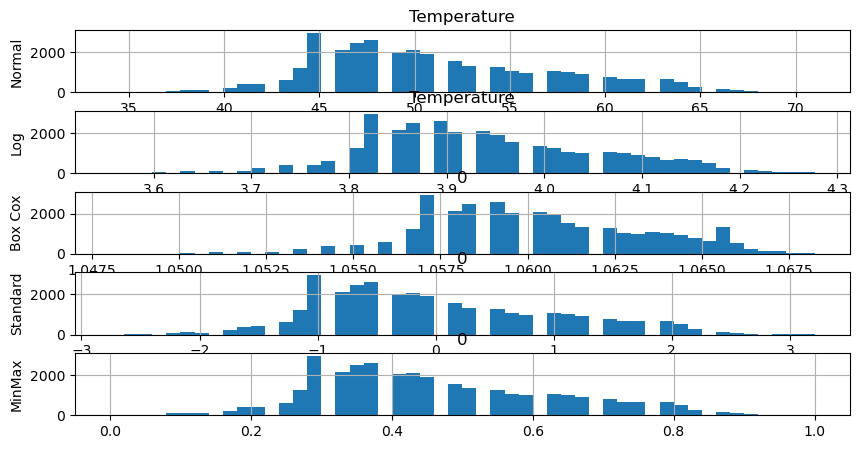

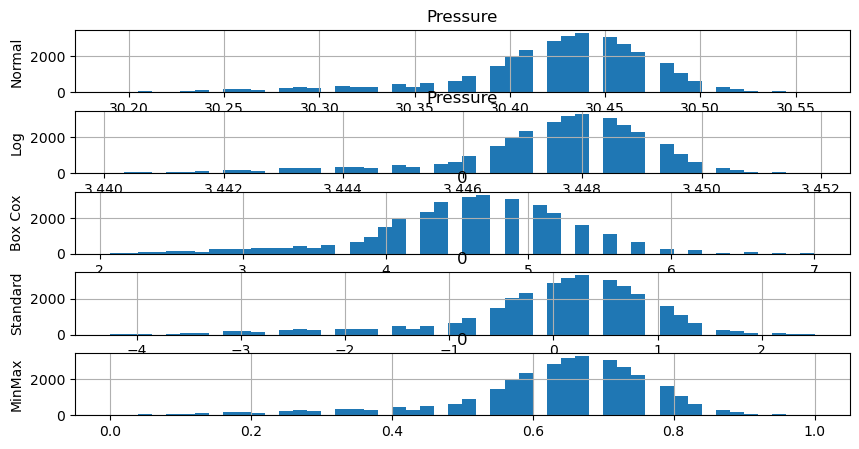

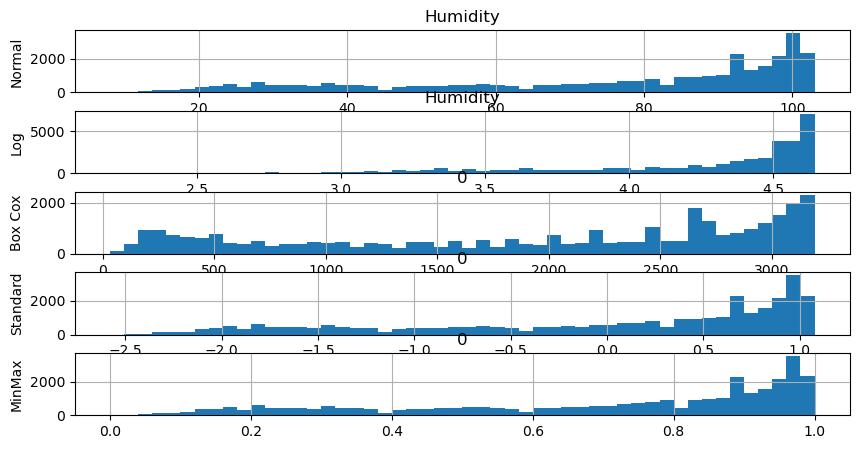

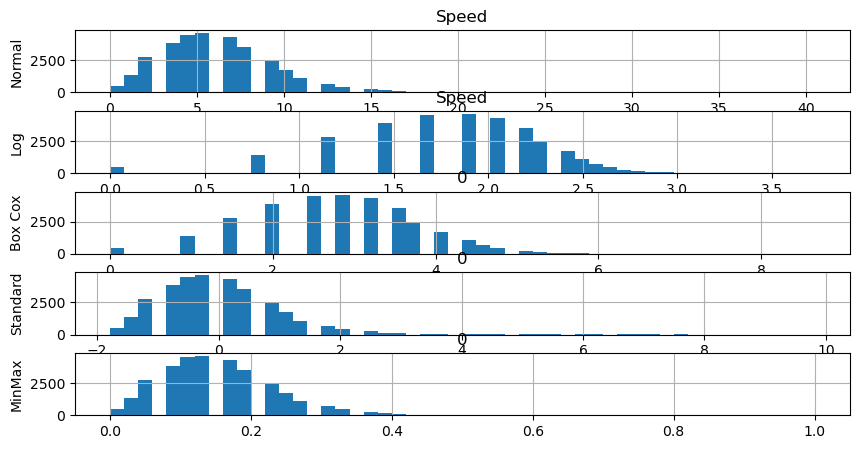

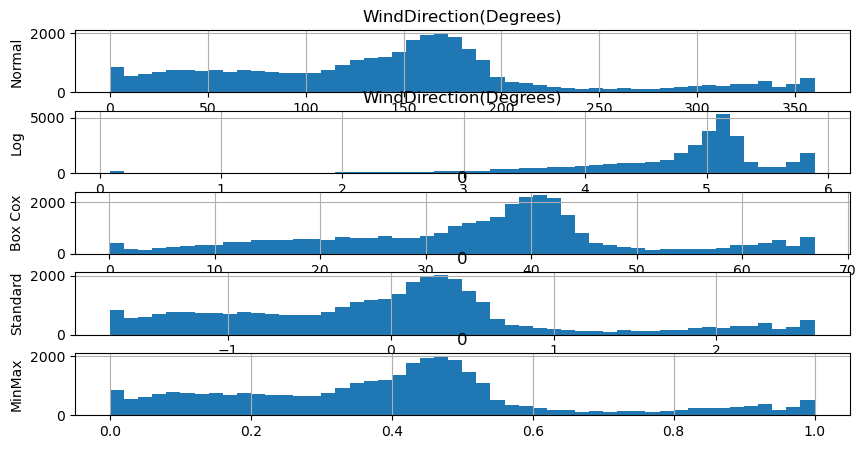

In [41]:
features_to_transform=['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    
    #define the 5 five axis for 5 plotand they wil be subplot having 5 row and 1 col
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1,figsize=(10,5))
    
    #so everytime have information of i for temp i is 0
    #so first want to make normal dist
    #the 1st is the normal dist and 2is the log transformation so apply log that if value is 0 then so no apply log on 0 osadd 1 everytime and then apply log transformation
    #so everytimre get data paramter get log fot it in 2
    # in 3 apply boxplot transformation for this use scipy from stats here boxcox is a power transformation. it puts power to a your function and try to make it a balanced one and you will get value
    # now 4. apply standard scalar transformation and rearrange it
    #for 5. minmax scalar
    pd.DataFrame(input_features[i]).hist(ax=ax1,bins=50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax=ax2,bins=50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3,bins=50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax4,bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax=ax5,bins=50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

get above five feature different transformationnow. Now fig out which transformation we want so for that prepare data dictionary .
In the dict take one any transformation for one parameter that is mor normally distributed.

In [44]:
transform={'Temperature' : ((input_features['Temperature']+1).transform(np.log)),
           'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
           'Humidity' : stats.boxcox(input_features['Humidity']+1)[0],
           'Speed' : (input_features['Speed']+1).transform(np.log), 
           'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i]=transform[i]

In [47]:
input_features.head()#now data is transformed the target is to have normal dist

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


# Preparing data - Standardisation and Splitting

In [48]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [50]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

# Prediction with XGBoost

#XGBoost model use as name it is a boosting algo.how this are different from bagging techniquew
sample data put data --> in model and whatever performance fo the model this is weaker model -->the result put in another sample to another model and again for next model.

In [52]:
from xgboost import XGBRegressor

# declare parameters
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

#using xgbregressor which will used parameter for model
model = XGBRegressor(**params)

In [53]:
#train the model
model.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
y_pred=model.predict(xtest)

In [56]:
rmse=np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 81.87
R2: 0.93


# Using MultiLayer Perceptron for prediction

In [57]:
input_features.shape

(32686, 14)

In [69]:
#sequential==isplaceholder for all your layers that adding to the model
#Metrics Argument: The metrics argument should be provided as a list, even if you only have one metric.
model = None
model = Sequential()
    
model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.compile(metrics=['mse'], loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [70]:
#now train the model
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 156.1983 - mse: 88978.9375 - val_loss: 76.4844 - val_mse: 21832.5430
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 84.6115 - mse: 27056.7520 - val_loss: 68.8949 - val_mse: 18266.7559
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 81.3352 - mse: 24935.8047 - val_loss: 64.3724 - val_mse: 16100.5020
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 75.2644 - mse: 21798.3789 - val_loss: 61.4049 - val_mse: 14886.6230
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 74.0249 - mse: 21106.4160 - val_loss: 63.6496 - val_mse: 15997.8320
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 74.0743 - mse: 20992.4297 - val_loss: 56.7420 - val_mse: 13358.5254
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 71.4029 - mse: 19944.8008 - val_loss: 56.1364 - val_mse: 13319.2568
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 70.6823 - mse: 19658.1426 - val_loss: 54.7

In [71]:
#history.history is list of all losses and other mse and validation
history.history 

{'loss': [119.29060363769531,
  83.89997100830078,
  79.42738342285156,
  76.0584716796875,
  74.61929321289062,
  72.82064819335938,
  71.02684783935547,
  70.07070922851562,
  69.92158508300781,
  68.35203552246094,
  67.33137512207031,
  67.168701171875,
  67.02266693115234,
  66.31175231933594,
  65.54744720458984,
  65.7111587524414,
  65.41268920898438,
  65.69014739990234,
  63.50113296508789,
  64.7305679321289,
  64.00414276123047,
  63.637359619140625,
  63.50201416015625,
  63.813602447509766,
  63.54155349731445,
  63.43706130981445,
  63.111297607421875,
  63.04198455810547,
  62.0198974609375,
  62.41259765625,
  62.08129119873047,
  61.57197952270508,
  61.84285354614258,
  61.99480056762695,
  61.302547454833984,
  61.42405319213867,
  61.69284439086914,
  60.740509033203125,
  61.41476821899414,
  60.830631256103516,
  59.78150177001953,
  60.03183364868164,
  60.05392837524414,
  59.58750534057617,
  59.85212326049805,
  59.5372314453125,
  60.27713394165039,
  59.478

In [72]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 45.2300 - mse: 10033.1729
Mean absolute error:  43.688087463378906


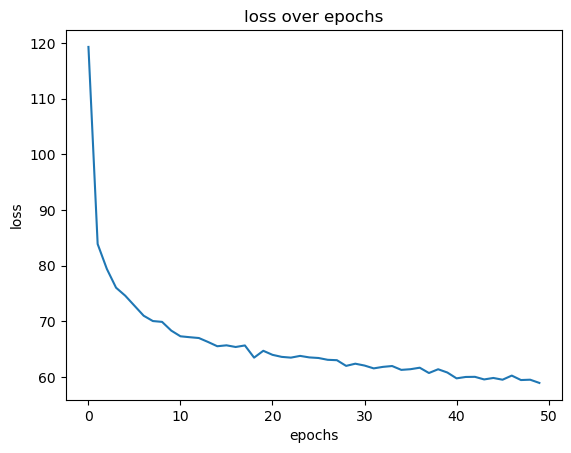

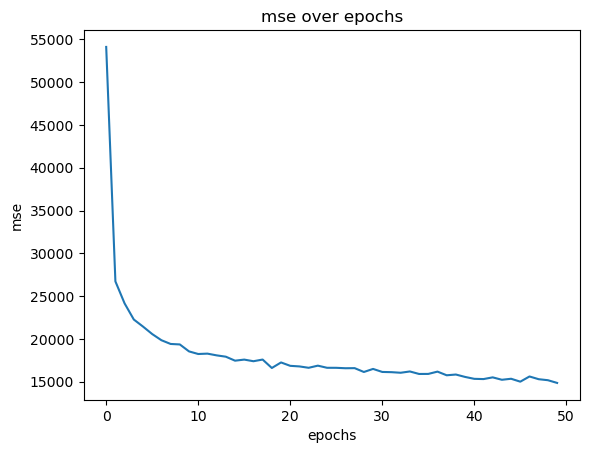

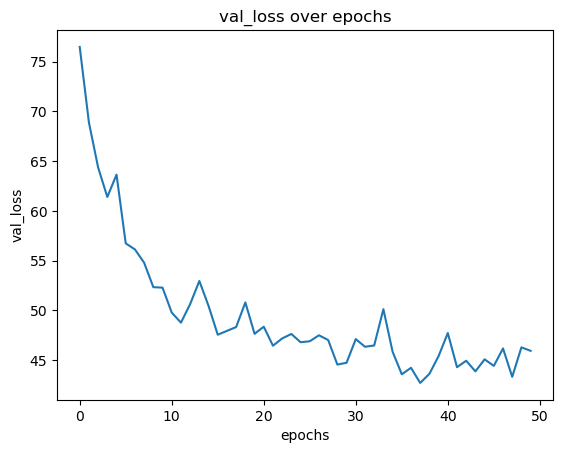

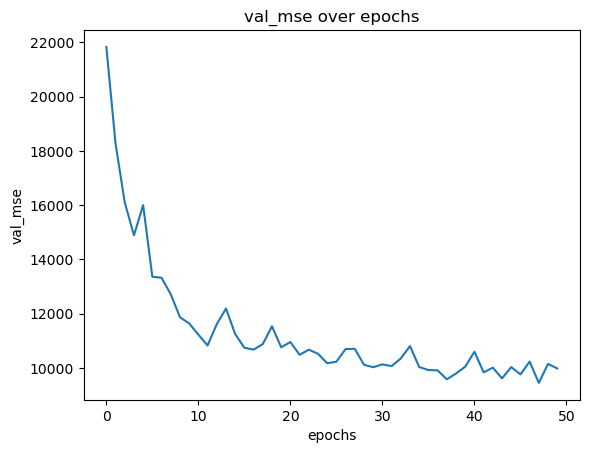

In [73]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [65]:
#so see model is doing at time of training so predict
y_pred=model.predict(xtest)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [74]:
mean_absolute_error(ytest, model.predict(xtsest))#ybat and y orginal

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


43.688092221849075

In [ ]:
s